In [1]:
!pip install torch transformers x-transformers betacal shap captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 9.5 MB/s eta 0:00:00


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 9.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 18.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.1 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 82.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 11.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 28.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 60.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 40.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 27.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.1/150.1 MB 33.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━

In [2]:
# # Basic imports
import numpy as np  # For numerical computations and array manipulations
import pandas as pd  # For loading and handling time-series and static data
import sys
import importlib
import os
import time
from tqdm import tqdm
# PyTorch imports
import torch  # Core PyTorch library
import torch.nn as nn  # Neural network layers and loss functions
import torch.optim as optim  # Optimization algorithms
from torch.utils.data import Dataset, DataLoader  # Datasets and DataLoaders for batching
from torch.nn import Transformer, TransformerEncoderLayer  # Transformer modules

# #Tranformers import
from transformers import AutoTokenizer, AutoModel

from sklearn.metrics import accuracy_score, precision_recall_curve, auc, roc_auc_score


module_path = '/home/workspace/files/MilanK/Model1/final_models/code'
# Add the module's directory to the system path if it's not already present
if module_path not in sys.path:
    sys.path.append(module_path)
    
    

from generating_datasets_for_torch import *
from load_static_data import *
from PatientDataset import *
from generate_labels_dataframe_with_dataloader import *
from load_train_test_split import *
from model import *
from load_patient_list import *
from forward_loop import *
from fit import *
from validate import *

In [3]:
train,val,test = load_train_test_data(
    train_filename = 'train_patient_list_orig.txt',                                   
    val_filename = 'val_patient_list_orig.txt',
    test_filename = 'test_patient_list.txt'
)



Training Set - Total Patients: 1214
Patients with Only Respiratory Deterioration: 7.50%
Patients with Only Cardiac Deterioration: 13.01%
Patients with Both Respiratory and Cardiac Deterioration: 5.93%
Patients with No Deterioration: 73.56%

Training Set - Total Windows: 8109
Windows with Only Respiratory Deterioration: 2.48%
Windows with Only Cardiac Deterioration: 4.06%
Windows with Both Respiratory and Cardiac Deterioration: 0.57%
Windows with No Deterioration: 92.90%

Validation Set - Total Patients: 150
Patients with Only Respiratory Deterioration: 4.67%
Patients with Only Cardiac Deterioration: 16.67%
Patients with Both Respiratory and Cardiac Deterioration: 6.00%
Patients with No Deterioration: 72.67%

Validation Set - Total Windows: 1022
Windows with Only Respiratory Deterioration: 2.25%
Windows with Only Cardiac Deterioration: 5.19%
Windows with Both Respiratory and Cardiac Deterioration: 0.59%
Windows with No Deterioration: 91.98%

Testing Set - Total Patients: 155
Patients wi

In [4]:
train_dataset = PatientDataset(patient_list = train, min_window_min=15, step_min=15,max_window_min=15,
                             prediction_window_length=15)


val_dataset = PatientDataset(patient_list = val, min_window_min=15, step_min=15,max_window_min=15,
                             prediction_window_length=15)



Generating 15-min samples: 100%|██████████| 1214/1214 [01:06<00:00, 18.17it/s]


Number of windows without minority oversampling: 8109


Generating 15-min samples: 100%|██████████| 150/150 [00:07<00:00, 20.22it/s]


Number of windows without minority oversampling: 1022


In [5]:
batch_size = 64
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,             # Number of worker processes
    #prefetch_factor=1,          # Number of batches to preload per worker
    #persistent_workers=True      # Keep workers alive across epochs
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    #prefetch_factor=1,
    #persistent_workers=True
)


In [6]:
batch_size = 64

model = run_exp(experiment_name = 'combined_model_simpler_demographics',
            train_loader = train_loader,
            val_loader = val_loader,
            depth=2,
            heads=2,
            dynamic_dim_in=18,
            dynamic_dim_out=64,
            max_seq_len=924,
            attn_dropout=0,
            ff_dropout=0,
            batch_norm=False,
            scalar_input_dim = 40,
            scalar_mlp_hidden_dim=256,
            embedding_hidden_dim=256,
            ensemble_mlp_hidden_dim=512,
            output_dim=1,
            l1_lambda=0,
            l2_lambda=0,
            lr=3e-5,
            pos_weight_value=30.0,
            epochs = 10,
            max_norm=10,
            patience=10,
            lr_patience=100,
            device="cpu",
            target_outcome = 'resp')

Loaded saved model weights from checkpoint.
Epoch 1/9


W0404 13:17:44.778000 134 site-packages/torch/_dynamo/variables/builtin.py:783] [0/0] incorrect arg count <bound method BuiltinVariable.call_next of BuiltinVariable(next)> too many positional arguments and no constant handler
W0404 13:17:44.923000 134 site-packages/torch/_dynamo/variables/builtin.py:783] [1/0] incorrect arg count <bound method BuiltinVariable.call_next of BuiltinVariable(next)> too many positional arguments and no constant handler
W0404 13:17:45.070000 134 site-packages/torch/_dynamo/variables/builtin.py:783] [2/0] incorrect arg count <bound method BuiltinVariable.call_next of BuiltinVariable(next)> too many positional arguments and no constant handler
W0404 13:17:56.467000 134 site-packages/torch/_dynamo/variables/builtin.py:783] [3/0] incorrect arg count <bound method BuiltinVariable.call_next of BuiltinVariable(next)> too many positional arguments and no constant handler
W0404 13:17:59.051000 134 site-packages/torch/_dynamo/variables/builtin.py:783] [4/0] incorrect 

Epoch completed in 415.43s, Average Training Loss: 0.8461


W0404 13:24:29.798000 134 site-packages/torch/_dynamo/variables/builtin.py:783] [0/2] incorrect arg count <bound method BuiltinVariable.call_next of BuiltinVariable(next)> too many positional arguments and no constant handler
W0404 13:24:29.976000 134 site-packages/torch/_dynamo/variables/builtin.py:783] [1/2] incorrect arg count <bound method BuiltinVariable.call_next of BuiltinVariable(next)> too many positional arguments and no constant handler
W0404 13:24:30.167000 134 site-packages/torch/_dynamo/variables/builtin.py:783] [2/2] incorrect arg count <bound method BuiltinVariable.call_next of BuiltinVariable(next)> too many positional arguments and no constant handler
W0404 13:24:30.394000 134 site-packages/torch/_dynamo/variables/builtin.py:783] [3/2] incorrect arg count <bound method BuiltinVariable.call_next of BuiltinVariable(next)> too many positional arguments and no constant handler


Validation AUC-PR for resp: 0.1534
Validation AUROC for resp: 0.8892
Validation Loss: 0.7606
Validation AUPRC: 0.1534, Validation AUROC: 0.8892
Model weights saved for epoch 1
Epoch 1/9, Current Learning Rate: 0.000030
Epoch 2/9
Epoch completed in 128.12s, Average Training Loss: 0.8335
Validation AUC-PR for resp: 0.1635
Validation AUROC for resp: 0.8938
Validation Loss: 0.7575
Validation AUPRC: 0.1635, Validation AUROC: 0.8938
Model weights saved for epoch 2
Epoch 2/9, Current Learning Rate: 0.000030
Epoch 3/9
Epoch completed in 128.80s, Average Training Loss: 0.8187
Validation AUC-PR for resp: 0.1595
Validation AUROC for resp: 0.8927
Validation Loss: 0.7380
Validation AUPRC: 0.1595, Validation AUROC: 0.8927
Model weights saved for epoch 3
Epoch 3/9, Current Learning Rate: 0.000030
Epoch 4/9
Epoch completed in 129.77s, Average Training Loss: 0.8003
Validation AUC-PR for resp: 0.1631
Validation AUROC for resp: 0.8949
Validation Loss: 0.7321
Validation AUPRC: 0.1631, Validation AUROC: 0.

Loading model from: /home/workspace/files/MilanK/Model1/final_models/final_resp_models/combined_model_simpler_demographics/combined_model_simpler_demographics.pth
Loaded saved model weights.
Model has been frozen.


Generating 15-min samples: 100%|██████████| 155/155 [00:06<00:00, 22.63it/s]


Number of windows without minority oversampling: 1031


W0404 13:53:26.654000 134 site-packages/torch/_dynamo/variables/builtin.py:783] [3/4] incorrect arg count <bound method BuiltinVariable.call_next of BuiltinVariable(next)> too many positional arguments and no constant handler


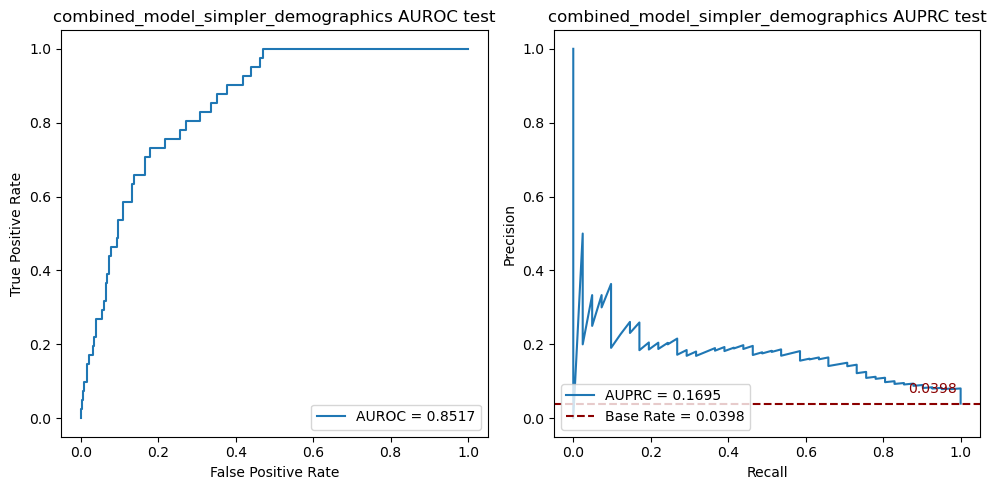

Best Threshold (FPR ≈ 0.2): 0.5228
Sensitivity (Recall): 0.7317
Specificity: 0.8212


NameError: name 'fpr' is not defined

In [8]:
model = load_model_for_eval()
test_dataset = PatientDataset(patient_list = test, min_window_min=15, step_min=15,max_window_min=15,
                             prediction_window_length=15)


test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    #prefetch_factor=1,
    #persistent_workers=True
)



plot_curves(device = 'cpu', 
            model = model,
            data_loader = test_loader,
            pos_weight = 30,
            exp_name = 'combined_model_simpler_demographics',
            exp_dataset = 'test')

In [ ]:
model = load_model_for_eval()
plot_curves(device = 'cpu', 
            model = model,
            data_loader = train_loader,
            pos_weight = 30,
            exp_name = 'combined_model_simpler_demographics',
            exp_dataset = 'test')